# HAR (human activity recognition) using DNN/DL on IMU data

In [1]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

# test and train read
Xtrain, Ytrain, _ = read_data(data_path="/home/arasdar/datasets/har-data/", split="train")
Xtest, Ytest, _ = read_data(data_path="/home/arasdar/datasets/har-data/", split="test")

# assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Ytrain.max(axis=0) == Ytest.max(axis=0), 'Mismatch in channels of Ytrain and Ytest'

# balanced data or not
print(np.mean(Ytrain==1), np.mean(Ytrain==2), np.mean(Ytrain==3), 
      np.mean(Ytrain==4), np.mean(Ytrain==5), np.mean(Ytrain==6))

print(Xtrain.shape, Xtrain.dtype, Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype)

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125
(7352, 128, 9) float64 (2947, 128, 9) float64
(7352,) int64 (2947,) int64


In [2]:
from sklearn.model_selection import train_test_split

# Now separating train and validation set
# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Xtest.shape, Xtrain.dtype, Xvalid.dtype, Xtest.dtype)
print(Ytrain.shape, Yvalid.shape, Ytest.shape, Ytrain.dtype, Yvalid.dtype, Ytest.dtype)

(5146, 128, 9) (2206, 128, 9) (2947, 128, 9) float64 float64 float64
(5146,) (2206,) (2947,) int64 int64 int64


In [3]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [4]:
def model_input(input_size, output_size):
    #     N, W, Cin = Xvalid.shape[0], Xvalid.shape[1], Xvalid.shape[2]
    Xinputs = tf.placeholder(dtype=tf.float32, shape=[None, *input_size], name='Xinputs')
    
    #     N, Cout = Yvalid.shape[0], Yvalid.shape[1]
    Yindices = tf.placeholder(dtype=tf.int32, shape=[None], name='Yindices')
    
    # Training mode or inference mode for batchnorm
    training = tf.placeholder(dtype=tf.bool, shape=[], name=None)
    
    # returning input data/sequences, output labels/classes, training mode for batchnorm
    return Xinputs, Yindices, training

In [6]:
# Discriminator/ classifier/ recognizer
def discriminator(Xinputs, input_size, output_size, hidden_size, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Flatten/Vectorize the input data tensor for FC/fully connected layer/Dense Layer
        Xinputs_vec = tf.reshape(tensor=Xinputs, shape=[-1, input_size[0]*input_size[1]])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=Xinputs_vec, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=output_size)   
        #predictions = tf.nn.softmax(logits)
        
        # return output logits for loss and accuracy
        return logits

In [7]:
# This is the forward propagation of the model to calculate the loss.
def model_loss(Xinputs, Yindices, input_size, output_size, hidden_size, training=True):
    
    # Creating logits and labels
    Ylogits = discriminator(Xinputs=Xinputs, input_size=input_size, output_size=output_size, training=training, 
                            hidden_size=hidden_size)
    Ylabels = tf.one_hot(indices=Yindices, depth=output_size, dtype=Ylogits.dtype)
    
    # Loss using logits and labels
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Ylabels))
    
    # Accuracy using logits and labels
    acc_tensor = tf.equal(x=tf.argmax(axis=1, input=Ylogits), y=tf.argmax(axis=1, input=Ylabels))
    acc = tf.reduce_mean(axis=0, input_tensor=tf.cast(dtype=tf.float32, x=acc_tensor))

    # returning loss and accuracy
    return loss, acc

In [8]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()

    # Optimize: This part is required to batchnorm
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=t_vars)

    return opt

In [9]:
class MLP:
    def __init__(self, input_size, output_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.Xinputs, self.Yindices, self.training = model_input(input_size=input_size, output_size=output_size)

        # Create the Model: calculating the loss and forwad pass
        self.loss, self.acc = model_loss(Xinputs=self.Xinputs, Yindices=self.Yindices, training=self.training,
                                         input_size=input_size, output_size=output_size, hidden_size=hidden_size)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)
        #self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [10]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [20]:
# Network Hyper-parameters

# Number of classes Output layer or target labels
assert Ytrain.max()==Ytest.max()==Yvalid.max(), 'Number of output classes is the same in training, validation and testing data.'

# Hidden layer
input_size = [Xvalid.shape[1], Xvalid.shape[2]]
hidden_size = Xvalid.shape[1]* Xvalid.shape[2]
output_size = Yvalid.max()

# learning parameters
batch_size = Xvalid.shape[0]//1  # experience mini-batch size
train_epochs = 2000              # max number of training episodes/epochs
learning_rate = 0.001            # learning rate for training/optimization/adam

In [21]:
print('Yvalid.max(), Yvalid.min():', Yvalid.max(), Yvalid.min())
print('Yvalid.shape:', Yvalid.shape)
print('Xvalid.shape:', Xvalid.shape)

Yvalid.max(), Yvalid.min(): 6 1
Yvalid.shape: (2206,)
Xvalid.shape: (2206, 128, 9)


In [22]:
tf.reset_default_graph()

model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=learning_rate)

In [23]:
# We should save the after training and validation
saver = tf.train.Saver() 

# Loss and accuracy of the model for training and validation
train_loss_mean, valid_loss_mean = [], []
train_acc_mean, valid_acc_mean = [], []

# now that we can calculate loss and optimize, we can start a session for calculating the error.
with tf.Session() as sess:
    
    # Initialize all the model parameters/variables
    sess.run(fetches=tf.global_variables_initializer())
    
    #     # Restoring/loading/uploading the trained and validated model
    #     saver.restore(sess,'checkpoints/mlp-fnirs-har.ckpt')
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # for every epoch start feeding the arrays into the tensors in the model
    for epoch in range(train_epochs):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        
        # Training
        for Xinputs, Yindices in get_batches(X=Xtrain, Y=Ytrain, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices, model.training: True}
            loss, acc, _ = sess.run(fetches=[model.loss, model.acc, model.opt], feed_dict=feed_dict)
            train_loss.append(loss)
            train_acc.append(acc)
            
        # printing out train and validation loss
        print('epoch:', epoch+1, 'train_loss:', np.mean(train_loss), 'train_acc:', np.mean(train_acc))
        
        # Saving the losses for plotting
        train_loss_mean.append(np.mean(train_loss))
        train_acc_mean.append(np.mean(train_acc))
        
        # Validation
        for Xinputs, Yindices in get_batches(X=Xvalid, Y=Yvalid, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices, model.training: False}
            loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
            valid_loss.append(loss)
            valid_acc.append(acc)
        
        # printing out train and validation loss
        print('epoch:', epoch+1, 'valid_loss:', np.mean(valid_loss), 'valid_acc:', np.mean(valid_acc))

        # Saving the losses for plotting
        valid_loss_mean.append(np.mean(valid_loss))
        valid_acc_mean.append(np.mean(valid_acc))        
    
    # Saving the trained and validated model
    saver.save(sess,'checkpoints/model-imu.ckpt')

epoch: 1 train_loss: 1.2468374 train_acc: 0.31958294
epoch: 1 valid_loss: 1.6415792 valid_acc: 0.26881233
epoch: 2 train_loss: 0.4397233 train_acc: 0.7350408
epoch: 2 valid_loss: 3.7914622 valid_acc: 0.13916591
epoch: 3 train_loss: 0.47275692 train_acc: 0.63871264
epoch: 3 valid_loss: 6.338972 valid_acc: 0.14505893
epoch: 4 train_loss: 0.3446254 train_acc: 0.69084316
epoch: 4 valid_loss: 8.360851 valid_acc: 0.13689937
epoch: 5 train_loss: 0.25519958 train_acc: 0.738214
epoch: 5 valid_loss: 9.858748 valid_acc: 0.13463283
epoch: 6 train_loss: 0.25304598 train_acc: 0.7359474
epoch: 6 valid_loss: 10.925887 valid_acc: 0.13825929
epoch: 7 train_loss: 0.24460295 train_acc: 0.7398006
epoch: 7 valid_loss: 11.976681 valid_acc: 0.14233908
epoch: 8 train_loss: 0.22756842 train_acc: 0.7370807
epoch: 8 valid_loss: 13.090638 valid_acc: 0.1432457
epoch: 9 train_loss: 0.21720727 train_acc: 0.74388033
epoch: 9 valid_loss: 14.124517 valid_acc: 0.14052583
epoch: 10 train_loss: 0.2044749 train_acc: 0.75453

epoch: 80 train_loss: 0.10004087 train_acc: 0.7737987
epoch: 80 valid_loss: 7.840329 valid_acc: 0.14052583
epoch: 81 train_loss: 0.099684805 train_acc: 0.7735721
epoch: 81 valid_loss: 7.7675977 valid_acc: 0.14097914
epoch: 82 train_loss: 0.09897328 train_acc: 0.77425206
epoch: 82 valid_loss: 7.6993027 valid_acc: 0.14097914
epoch: 83 train_loss: 0.098590896 train_acc: 0.7735721
epoch: 83 valid_loss: 7.643993 valid_acc: 0.14097914
epoch: 84 train_loss: 0.09832785 train_acc: 0.77515864
epoch: 84 valid_loss: 7.605387 valid_acc: 0.14097914
epoch: 85 train_loss: 0.0983933 train_acc: 0.77515864
epoch: 85 valid_loss: 7.5810246 valid_acc: 0.14097914
epoch: 86 train_loss: 0.097265065 train_acc: 0.77810514
epoch: 86 valid_loss: 7.5335774 valid_acc: 0.14097914
epoch: 87 train_loss: 0.09666386 train_acc: 0.77742517
epoch: 87 valid_loss: 7.4612455 valid_acc: 0.14143246
epoch: 88 train_loss: 0.09686561 train_acc: 0.7776519
epoch: 88 valid_loss: 7.3406277 valid_acc: 0.14188577
epoch: 89 train_loss: 0.

epoch: 158 train_loss: 0.073533 train_acc: 0.78422487
epoch: 158 valid_loss: 9.464417 valid_acc: 0.15911151
epoch: 159 train_loss: 0.08234531 train_acc: 0.78603804
epoch: 159 valid_loss: 9.15668 valid_acc: 0.15276518
epoch: 160 train_loss: 0.07640551 train_acc: 0.7839982
epoch: 160 valid_loss: 9.269963 valid_acc: 0.15593836
epoch: 161 train_loss: 0.07692745 train_acc: 0.781505
epoch: 161 valid_loss: 9.709706 valid_acc: 0.1631913
epoch: 162 train_loss: 0.084971875 train_acc: 0.78513145
epoch: 162 valid_loss: 9.1847515 valid_acc: 0.15639167
epoch: 163 train_loss: 0.074732125 train_acc: 0.7835449
epoch: 163 valid_loss: 9.305747 valid_acc: 0.15639167
epoch: 164 train_loss: 0.07598817 train_acc: 0.7835449
epoch: 164 valid_loss: 9.481948 valid_acc: 0.16364461
epoch: 165 train_loss: 0.07800751 train_acc: 0.7858114
epoch: 165 valid_loss: 9.378999 valid_acc: 0.1631913
epoch: 166 train_loss: 0.07576099 train_acc: 0.7855848
epoch: 166 valid_loss: 9.449867 valid_acc: 0.16001813
epoch: 167 train_lo

epoch: 233 valid_loss: 8.951899 valid_acc: 0.26019946
epoch: 234 train_loss: 0.06592581 train_acc: 0.78966457
epoch: 234 valid_loss: 9.45785 valid_acc: 0.26019946
epoch: 235 train_loss: 0.06982773 train_acc: 0.7896645
epoch: 235 valid_loss: 8.947186 valid_acc: 0.26019946
epoch: 236 train_loss: 0.06771097 train_acc: 0.7903445
epoch: 236 valid_loss: 8.983655 valid_acc: 0.26110607
epoch: 237 train_loss: 0.06832744 train_acc: 0.7905712
epoch: 237 valid_loss: 8.704812 valid_acc: 0.25974613
epoch: 238 train_loss: 0.07106574 train_acc: 0.7905712
epoch: 238 valid_loss: 8.684243 valid_acc: 0.262466
epoch: 239 train_loss: 0.06687884 train_acc: 0.7903445
epoch: 239 valid_loss: 8.87925 valid_acc: 0.26563916
epoch: 240 train_loss: 0.076132156 train_acc: 0.78762466
epoch: 240 valid_loss: 8.510255 valid_acc: 0.2615594
epoch: 241 train_loss: 0.07322019 train_acc: 0.7914778
epoch: 241 valid_loss: 8.133721 valid_acc: 0.26110607
epoch: 242 train_loss: 0.06706694 train_acc: 0.7907978
epoch: 242 valid_loss

epoch: 309 valid_loss: 9.917008 valid_acc: 0.27153218
epoch: 310 train_loss: 0.07793215 train_acc: 0.7935177
epoch: 310 valid_loss: 9.925837 valid_acc: 0.27289212
epoch: 311 train_loss: 0.06978846 train_acc: 0.7923844
epoch: 311 valid_loss: 10.5776415 valid_acc: 0.2719855
epoch: 312 train_loss: 0.07895589 train_acc: 0.7923844
epoch: 312 valid_loss: 10.432808 valid_acc: 0.27289212
epoch: 313 train_loss: 0.07204813 train_acc: 0.79283774
epoch: 313 valid_loss: 9.825163 valid_acc: 0.27379873
epoch: 314 train_loss: 0.07301868 train_acc: 0.7923844
epoch: 314 valid_loss: 9.436016 valid_acc: 0.2719855
epoch: 315 train_loss: 0.07211708 train_acc: 0.7946509
epoch: 315 valid_loss: 10.74758 valid_acc: 0.2719855
epoch: 316 train_loss: 0.07473269 train_acc: 0.7907978
epoch: 316 valid_loss: 10.307353 valid_acc: 0.2724388
epoch: 317 train_loss: 0.070129335 train_acc: 0.7937443
epoch: 317 valid_loss: 9.882846 valid_acc: 0.2733454
epoch: 318 train_loss: 0.075190306 train_acc: 0.793971
epoch: 318 valid_l

epoch: 388 train_loss: 0.088654265 train_acc: 0.7887579
epoch: 388 valid_loss: 10.346226 valid_acc: 0.2679057
epoch: 389 train_loss: 0.0968729 train_acc: 0.7919311
epoch: 389 valid_loss: 10.06201 valid_acc: 0.27923843
epoch: 390 train_loss: 0.08968334 train_acc: 0.79283774
epoch: 390 valid_loss: 9.0438595 valid_acc: 0.2719855
epoch: 391 train_loss: 0.09029248 train_acc: 0.79261106
epoch: 391 valid_loss: 9.43943 valid_acc: 0.26971895
epoch: 392 train_loss: 0.083218426 train_acc: 0.79510427
epoch: 392 valid_loss: 10.16194 valid_acc: 0.2674524
epoch: 393 train_loss: 0.08920692 train_acc: 0.794651
epoch: 393 valid_loss: 10.066932 valid_acc: 0.27379873
epoch: 394 train_loss: 0.08259706 train_acc: 0.7955576
epoch: 394 valid_loss: 10.033882 valid_acc: 0.26971895
epoch: 395 train_loss: 0.09124178 train_acc: 0.79397094
epoch: 395 valid_loss: 8.772949 valid_acc: 0.27017227
epoch: 396 train_loss: 0.08181195 train_acc: 0.79397094
epoch: 396 valid_loss: 9.828351 valid_acc: 0.27017227
epoch: 397 tra

epoch: 463 train_loss: 0.09133904 train_acc: 0.7962376
epoch: 463 valid_loss: 8.524637 valid_acc: 0.26110607
epoch: 464 train_loss: 0.09428284 train_acc: 0.7955576
epoch: 464 valid_loss: 8.88863 valid_acc: 0.2679057
epoch: 465 train_loss: 0.09458092 train_acc: 0.79759747
epoch: 465 valid_loss: 7.531682 valid_acc: 0.26881233
epoch: 466 train_loss: 0.09860894 train_acc: 0.7969175
epoch: 466 valid_loss: 6.002313 valid_acc: 0.2824116
epoch: 467 train_loss: 0.0890155 train_acc: 0.79487765
epoch: 467 valid_loss: 8.071946 valid_acc: 0.25974613
epoch: 468 train_loss: 0.10063736 train_acc: 0.79510427
epoch: 468 valid_loss: 9.044452 valid_acc: 0.26110607
epoch: 469 train_loss: 0.09698697 train_acc: 0.7969175
epoch: 469 valid_loss: 7.922857 valid_acc: 0.26382592
epoch: 470 train_loss: 0.10197772 train_acc: 0.79827744
epoch: 470 valid_loss: 5.961741 valid_acc: 0.2774252
epoch: 471 train_loss: 0.0924343 train_acc: 0.79510427
epoch: 471 valid_loss: 7.588611 valid_acc: 0.25929284
epoch: 472 train_los

epoch: 541 train_loss: 0.10333654 train_acc: 0.79601085
epoch: 541 valid_loss: 3.9652426 valid_acc: 0.3359021
epoch: 542 train_loss: 0.1117899 train_acc: 0.7948776
epoch: 542 valid_loss: 5.302132 valid_acc: 0.306437
epoch: 543 train_loss: 0.10026352 train_acc: 0.793971
epoch: 543 valid_loss: 6.214792 valid_acc: 0.28286493
epoch: 544 train_loss: 0.110397995 train_acc: 0.79510427
epoch: 544 valid_loss: 4.226781 valid_acc: 0.3363554
epoch: 545 train_loss: 0.11757119 train_acc: 0.7969175
epoch: 545 valid_loss: 3.2999566 valid_acc: 0.3862194
epoch: 546 train_loss: 0.09299809 train_acc: 0.79487765
epoch: 546 valid_loss: 6.225961 valid_acc: 0.27651858
epoch: 547 train_loss: 0.121317774 train_acc: 0.7964642
epoch: 547 valid_loss: 5.554232 valid_acc: 0.32366273
epoch: 548 train_loss: 0.09654483 train_acc: 0.7971442
epoch: 548 valid_loss: 4.6133184 valid_acc: 0.3009973
epoch: 549 train_loss: 0.115384266 train_acc: 0.79510427
epoch: 549 valid_loss: 3.767265 valid_acc: 0.3567543
epoch: 550 train_l

epoch: 616 valid_loss: 1.7570902 valid_acc: 0.4900272
epoch: 617 train_loss: 0.103979215 train_acc: 0.7989574
epoch: 617 valid_loss: 1.5389483 valid_acc: 0.5294651
epoch: 618 train_loss: 0.10553813 train_acc: 0.79782414
epoch: 618 valid_loss: 3.3454154 valid_acc: 0.40163192
epoch: 619 train_loss: 0.106711216 train_acc: 0.799184
epoch: 619 valid_loss: 2.7570958 valid_acc: 0.42384407
epoch: 620 train_loss: 0.110157296 train_acc: 0.8034905
epoch: 620 valid_loss: 1.8102947 valid_acc: 0.4904805
epoch: 621 train_loss: 0.10460116 train_acc: 0.7985041
epoch: 621 valid_loss: 1.6446472 valid_acc: 0.5077063
epoch: 622 train_loss: 0.10919781 train_acc: 0.79759747
epoch: 622 valid_loss: 1.8615004 valid_acc: 0.50362647
epoch: 623 train_loss: 0.10600646 train_acc: 0.7989574
epoch: 623 valid_loss: 3.21408 valid_acc: 0.39845875
epoch: 624 train_loss: 0.10506067 train_acc: 0.7985041
epoch: 624 valid_loss: 2.1310809 valid_acc: 0.4596555
epoch: 625 train_loss: 0.107955575 train_acc: 0.8000907
epoch: 625 v

epoch: 694 train_loss: 0.11525501 train_acc: 0.79873073
epoch: 694 valid_loss: 0.83517104 valid_acc: 0.6591115
epoch: 695 train_loss: 0.11812628 train_acc: 0.7991841
epoch: 695 valid_loss: 1.440341 valid_acc: 0.5883953
epoch: 696 train_loss: 0.10434504 train_acc: 0.80099726
epoch: 696 valid_loss: 1.9074421 valid_acc: 0.519039
epoch: 697 train_loss: 0.12018721 train_acc: 0.7994107
epoch: 697 valid_loss: 1.0436833 valid_acc: 0.6355394
epoch: 698 train_loss: 0.119138055 train_acc: 0.7994107
epoch: 698 valid_loss: 0.7316719 valid_acc: 0.6718042
epoch: 699 train_loss: 0.122298256 train_acc: 0.79782414
epoch: 699 valid_loss: 1.250863 valid_acc: 0.6201269
epoch: 700 train_loss: 0.10790628 train_acc: 0.79895735
epoch: 700 valid_loss: 1.6806818 valid_acc: 0.5589302
epoch: 701 train_loss: 0.12192166 train_acc: 0.79805076
epoch: 701 valid_loss: 1.1904595 valid_acc: 0.6228468
epoch: 702 train_loss: 0.114632584 train_acc: 0.800544
epoch: 702 valid_loss: 0.7291327 valid_acc: 0.6767906
epoch: 703 tra

epoch: 769 valid_loss: 0.6479703 valid_acc: 0.6822303
epoch: 770 train_loss: 0.1154874 train_acc: 0.8016772
epoch: 770 valid_loss: 0.7363038 valid_acc: 0.67316407
epoch: 771 train_loss: 0.11786924 train_acc: 0.80122393
epoch: 771 valid_loss: 0.95579934 valid_acc: 0.6622847
epoch: 772 train_loss: 0.11594046 train_acc: 0.8053037
epoch: 772 valid_loss: 0.9339686 valid_acc: 0.66001815
epoch: 773 train_loss: 0.123927295 train_acc: 0.7996373
epoch: 773 valid_loss: 0.6335087 valid_acc: 0.6872167
epoch: 774 train_loss: 0.11292127 train_acc: 0.80054396
epoch: 774 valid_loss: 0.66350424 valid_acc: 0.68132365
epoch: 775 train_loss: 0.122640684 train_acc: 0.8014506
epoch: 775 valid_loss: 0.8890214 valid_acc: 0.6631913
epoch: 776 train_loss: 0.11364709 train_acc: 0.7985041
epoch: 776 valid_loss: 0.909378 valid_acc: 0.6690843
epoch: 777 train_loss: 0.121147856 train_acc: 0.8014506
epoch: 777 valid_loss: 0.6711232 valid_acc: 0.6826836
epoch: 778 train_loss: 0.117978886 train_acc: 0.8000907
epoch: 778

epoch: 847 train_loss: 0.12582152 train_acc: 0.8000907
epoch: 847 valid_loss: 0.6887556 valid_acc: 0.67588395
epoch: 848 train_loss: 0.11756629 train_acc: 0.8021306
epoch: 848 valid_loss: 0.6024152 valid_acc: 0.69129646
epoch: 849 train_loss: 0.1274454 train_acc: 0.8021306
epoch: 849 valid_loss: 0.5454981 valid_acc: 0.69129646
epoch: 850 train_loss: 0.12225272 train_acc: 0.8023572
epoch: 850 valid_loss: 0.54359704 valid_acc: 0.6931097
epoch: 851 train_loss: 0.12340315 train_acc: 0.79986405
epoch: 851 valid_loss: 0.602439 valid_acc: 0.6872167
epoch: 852 train_loss: 0.122215524 train_acc: 0.8025839
epoch: 852 valid_loss: 0.6583949 valid_acc: 0.68087035
epoch: 853 train_loss: 0.1256473 train_acc: 0.8032638
epoch: 853 valid_loss: 0.55180824 valid_acc: 0.6899365
epoch: 854 train_loss: 0.12224562 train_acc: 0.8023572
epoch: 854 valid_loss: 0.5367203 valid_acc: 0.69628286
epoch: 855 train_loss: 0.12370778 train_acc: 0.8016772
epoch: 855 valid_loss: 0.65244615 valid_acc: 0.6795104
epoch: 856 t

epoch: 921 valid_loss: 0.5335758 valid_acc: 0.68359023
epoch: 922 train_loss: 0.12712999 train_acc: 0.8025838
epoch: 922 valid_loss: 0.5369973 valid_acc: 0.6922031
epoch: 923 train_loss: 0.13006906 train_acc: 0.8023572
epoch: 923 valid_loss: 0.5183438 valid_acc: 0.6899365
epoch: 924 train_loss: 0.12606151 train_acc: 0.8023572
epoch: 924 valid_loss: 0.5446477 valid_acc: 0.69084316
epoch: 925 train_loss: 0.1255756 train_acc: 0.8032638
epoch: 925 valid_loss: 0.55692655 valid_acc: 0.68132365
epoch: 926 train_loss: 0.13683608 train_acc: 0.80281055
epoch: 926 valid_loss: 0.5345046 valid_acc: 0.68631005
epoch: 927 train_loss: 0.12758991 train_acc: 0.8021306
epoch: 927 valid_loss: 0.5221492 valid_acc: 0.69401634
epoch: 928 train_loss: 0.13162227 train_acc: 0.80303717
epoch: 928 valid_loss: 0.5728076 valid_acc: 0.6903899
epoch: 929 train_loss: 0.12552704 train_acc: 0.80077064
epoch: 929 valid_loss: 0.5576093 valid_acc: 0.6795104
epoch: 930 train_loss: 0.13050461 train_acc: 0.8048504
epoch: 930 

epoch: 997 valid_loss: 0.518344 valid_acc: 0.69084316
epoch: 998 train_loss: 0.1303046 train_acc: 0.80122393
epoch: 998 valid_loss: 0.51850224 valid_acc: 0.6926564
epoch: 999 train_loss: 0.1357351 train_acc: 0.80122393
epoch: 999 valid_loss: 0.52492976 valid_acc: 0.68857664
epoch: 1000 train_loss: 0.1306728 train_acc: 0.8019039
epoch: 1000 valid_loss: 0.51393694 valid_acc: 0.6926564
epoch: 1001 train_loss: 0.13330443 train_acc: 0.8019039
epoch: 1001 valid_loss: 0.51359224 valid_acc: 0.69084316
epoch: 1002 train_loss: 0.15001506 train_acc: 0.8021306
epoch: 1002 valid_loss: 0.52382505 valid_acc: 0.68857664
epoch: 1003 train_loss: 0.12609163 train_acc: 0.8003173
epoch: 1003 valid_loss: 0.5405989 valid_acc: 0.68767
epoch: 1004 train_loss: 0.1460964 train_acc: 0.80077064
epoch: 1004 valid_loss: 0.5082002 valid_acc: 0.68359023
epoch: 1005 train_loss: 0.1378083 train_acc: 0.8016772
epoch: 1005 valid_loss: 0.5298944 valid_acc: 0.6849501
epoch: 1006 train_loss: 0.13777098 train_acc: 0.7991841
e

epoch: 1071 train_loss: 0.13306534 train_acc: 0.80349046
epoch: 1071 valid_loss: 0.56351525 valid_acc: 0.6881233
epoch: 1072 train_loss: 0.13759959 train_acc: 0.80281055
epoch: 1072 valid_loss: 0.53620684 valid_acc: 0.68676335
epoch: 1073 train_loss: 0.1352506 train_acc: 0.80371714
epoch: 1073 valid_loss: 0.5357036 valid_acc: 0.68767
epoch: 1074 train_loss: 0.13820526 train_acc: 0.80394375
epoch: 1074 valid_loss: 0.5603925 valid_acc: 0.68767
epoch: 1075 train_loss: 0.13617429 train_acc: 0.8032638
epoch: 1075 valid_loss: 0.57748866 valid_acc: 0.68767
epoch: 1076 train_loss: 0.133944 train_acc: 0.80326384
epoch: 1076 valid_loss: 0.5463996 valid_acc: 0.6872167
epoch: 1077 train_loss: 0.13639876 train_acc: 0.8039438
epoch: 1077 valid_loss: 0.52961284 valid_acc: 0.68585676
epoch: 1078 train_loss: 0.14092997 train_acc: 0.80394375
epoch: 1078 valid_loss: 0.55436057 valid_acc: 0.68767
epoch: 1079 train_loss: 0.13031743 train_acc: 0.80349046
epoch: 1079 valid_loss: 0.600251 valid_acc: 0.6863100

epoch: 1146 valid_loss: 0.5594997 valid_acc: 0.69174975
epoch: 1147 train_loss: 0.14047053 train_acc: 0.80371714
epoch: 1147 valid_loss: 0.55969155 valid_acc: 0.693563
epoch: 1148 train_loss: 0.14088404 train_acc: 0.8032638
epoch: 1148 valid_loss: 0.5488401 valid_acc: 0.68902993
epoch: 1149 train_loss: 0.13917837 train_acc: 0.80371714
epoch: 1149 valid_loss: 0.53881913 valid_acc: 0.6926564
epoch: 1150 train_loss: 0.14461228 train_acc: 0.8041705
epoch: 1150 valid_loss: 0.54289263 valid_acc: 0.6949229
epoch: 1151 train_loss: 0.14058134 train_acc: 0.8034905
epoch: 1151 valid_loss: 0.57636136 valid_acc: 0.69084316
epoch: 1152 train_loss: 0.13676861 train_acc: 0.8041705
epoch: 1152 valid_loss: 0.55139756 valid_acc: 0.69129646
epoch: 1153 train_loss: 0.14335167 train_acc: 0.8041705
epoch: 1153 valid_loss: 0.5325601 valid_acc: 0.69174975
epoch: 1154 train_loss: 0.1399847 train_acc: 0.80371714
epoch: 1154 valid_loss: 0.5568517 valid_acc: 0.693563
epoch: 1155 train_loss: 0.13806343 train_acc: 0

epoch: 1220 train_loss: 0.14016151 train_acc: 0.8032638
epoch: 1220 valid_loss: 0.5701937 valid_acc: 0.6826836
epoch: 1221 train_loss: 0.1515118 train_acc: 0.8034905
epoch: 1221 valid_loss: 0.554037 valid_acc: 0.68767
epoch: 1222 train_loss: 0.14895895 train_acc: 0.8041705
epoch: 1222 valid_loss: 0.5795547 valid_acc: 0.6790571
epoch: 1223 train_loss: 0.15391707 train_acc: 0.80303717
epoch: 1223 valid_loss: 0.56359375 valid_acc: 0.6826836
epoch: 1224 train_loss: 0.14702193 train_acc: 0.80326384
epoch: 1224 valid_loss: 0.57600015 valid_acc: 0.6795104
epoch: 1225 train_loss: 0.14924733 train_acc: 0.80326384
epoch: 1225 valid_loss: 0.5469476 valid_acc: 0.6849501
epoch: 1226 train_loss: 0.15710409 train_acc: 0.80394375
epoch: 1226 valid_loss: 0.55577797 valid_acc: 0.68041706
epoch: 1227 train_loss: 0.14851943 train_acc: 0.80303717
epoch: 1227 valid_loss: 0.6017885 valid_acc: 0.68087035
epoch: 1228 train_loss: 0.1476112 train_acc: 0.80281055
epoch: 1228 valid_loss: 0.5600832 valid_acc: 0.682

epoch: 1294 valid_loss: 0.5482446 valid_acc: 0.69129646
epoch: 1295 train_loss: 0.15650532 train_acc: 0.80371714
epoch: 1295 valid_loss: 0.5607059 valid_acc: 0.6872167
epoch: 1296 train_loss: 0.14976847 train_acc: 0.8034905
epoch: 1296 valid_loss: 0.5620866 valid_acc: 0.68585676
epoch: 1297 train_loss: 0.16370538 train_acc: 0.8041705
epoch: 1297 valid_loss: 0.54694045 valid_acc: 0.6903899
epoch: 1298 train_loss: 0.15283093 train_acc: 0.80371714
epoch: 1298 valid_loss: 0.5883763 valid_acc: 0.6826836
epoch: 1299 train_loss: 0.15169916 train_acc: 0.8041705
epoch: 1299 valid_loss: 0.5675664 valid_acc: 0.68676335
epoch: 1300 train_loss: 0.16109633 train_acc: 0.8043971
epoch: 1300 valid_loss: 0.5474344 valid_acc: 0.6831369
epoch: 1301 train_loss: 0.15157785 train_acc: 0.80394375
epoch: 1301 valid_loss: 0.57895446 valid_acc: 0.6831369
epoch: 1302 train_loss: 0.15428913 train_acc: 0.80394375
epoch: 1302 valid_loss: 0.58355284 valid_acc: 0.68631005
epoch: 1303 train_loss: 0.1572243 train_acc: 0

epoch: 1370 train_loss: 0.1563558 train_acc: 0.80281055
epoch: 1370 valid_loss: 0.64663583 valid_acc: 0.6645512
epoch: 1371 train_loss: 0.17719167 train_acc: 0.80099726
epoch: 1371 valid_loss: 0.56913674 valid_acc: 0.6781505
epoch: 1372 train_loss: 0.18184161 train_acc: 0.8025839
epoch: 1372 valid_loss: 0.59300095 valid_acc: 0.6736174
epoch: 1373 train_loss: 0.15964387 train_acc: 0.79986405
epoch: 1373 valid_loss: 0.6897944 valid_acc: 0.65956485
epoch: 1374 train_loss: 0.18003802 train_acc: 0.8021306
epoch: 1374 valid_loss: 0.58637655 valid_acc: 0.6727108
epoch: 1375 train_loss: 0.17728359 train_acc: 0.8019039
epoch: 1375 valid_loss: 0.56671953 valid_acc: 0.67633724
epoch: 1376 train_loss: 0.16595393 train_acc: 0.80281055
epoch: 1376 valid_loss: 0.61430305 valid_acc: 0.6718042
epoch: 1377 train_loss: 0.16952907 train_acc: 0.8032638
epoch: 1377 valid_loss: 0.593027 valid_acc: 0.67135084
epoch: 1378 train_loss: 0.1545483 train_acc: 0.8025838
epoch: 1378 valid_loss: 0.60285103 valid_acc: 

epoch: 1444 train_loss: 0.16912743 train_acc: 0.8034905
epoch: 1444 valid_loss: 0.58703625 valid_acc: 0.6722575
epoch: 1445 train_loss: 0.16661164 train_acc: 0.80371714
epoch: 1445 valid_loss: 0.6162355 valid_acc: 0.67135084
epoch: 1446 train_loss: 0.1714015 train_acc: 0.8034905
epoch: 1446 valid_loss: 0.6027704 valid_acc: 0.6727108
epoch: 1447 train_loss: 0.16720489 train_acc: 0.8041704
epoch: 1447 valid_loss: 0.5911293 valid_acc: 0.67089754
epoch: 1448 train_loss: 0.16288921 train_acc: 0.80371714
epoch: 1448 valid_loss: 0.5953478 valid_acc: 0.674524
epoch: 1449 train_loss: 0.16814631 train_acc: 0.8039438
epoch: 1449 valid_loss: 0.6092406 valid_acc: 0.6727108
epoch: 1450 train_loss: 0.17018777 train_acc: 0.8043971
epoch: 1450 valid_loss: 0.6235062 valid_acc: 0.67089754
epoch: 1451 train_loss: 0.16231939 train_acc: 0.80371714
epoch: 1451 valid_loss: 0.6164569 valid_acc: 0.6695376
epoch: 1452 train_loss: 0.16689241 train_acc: 0.8041705
epoch: 1452 valid_loss: 0.5948003 valid_acc: 0.6763

epoch: 1521 train_loss: 0.17389938 train_acc: 0.8034905
epoch: 1521 valid_loss: 0.62215257 valid_acc: 0.66545784
epoch: 1522 train_loss: 0.16667528 train_acc: 0.8039438
epoch: 1522 valid_loss: 0.6403729 valid_acc: 0.6613781
epoch: 1523 train_loss: 0.17082311 train_acc: 0.8041705
epoch: 1523 valid_loss: 0.62049437 valid_acc: 0.66999096
epoch: 1524 train_loss: 0.17652036 train_acc: 0.8043971
epoch: 1524 valid_loss: 0.6317274 valid_acc: 0.6668178
epoch: 1525 train_loss: 0.16953036 train_acc: 0.80371714
epoch: 1525 valid_loss: 0.63107324 valid_acc: 0.66545784
epoch: 1526 train_loss: 0.16822146 train_acc: 0.8039438
epoch: 1526 valid_loss: 0.6468595 valid_acc: 0.66273797
epoch: 1527 train_loss: 0.17089559 train_acc: 0.8039438
epoch: 1527 valid_loss: 0.61529505 valid_acc: 0.6690843
epoch: 1528 train_loss: 0.17911392 train_acc: 0.80394375
epoch: 1528 valid_loss: 0.62761486 valid_acc: 0.6668178
epoch: 1529 train_loss: 0.1651059 train_acc: 0.80303717
epoch: 1529 valid_loss: 0.65287364 valid_acc:

epoch: 1596 train_loss: 0.17621526 train_acc: 0.8039438
epoch: 1596 valid_loss: 0.60822666 valid_acc: 0.6736174
epoch: 1597 train_loss: 0.18164048 train_acc: 0.8041705
epoch: 1597 valid_loss: 0.6036855 valid_acc: 0.67316407
epoch: 1598 train_loss: 0.16999295 train_acc: 0.80371714
epoch: 1598 valid_loss: 0.6229136 valid_acc: 0.6695376
epoch: 1599 train_loss: 0.17762083 train_acc: 0.8039438
epoch: 1599 valid_loss: 0.5916531 valid_acc: 0.67633724
epoch: 1600 train_loss: 0.17888254 train_acc: 0.80371714
epoch: 1600 valid_loss: 0.61217505 valid_acc: 0.668631
epoch: 1601 train_loss: 0.1756476 train_acc: 0.80394375
epoch: 1601 valid_loss: 0.61694527 valid_acc: 0.67135084
epoch: 1602 train_loss: 0.17585509 train_acc: 0.8039438
epoch: 1602 valid_loss: 0.6119126 valid_acc: 0.6681777
epoch: 1603 train_loss: 0.17339863 train_acc: 0.8039438
epoch: 1603 valid_loss: 0.6136036 valid_acc: 0.6681777
epoch: 1604 train_loss: 0.18101849 train_acc: 0.8043971
epoch: 1604 valid_loss: 0.59770143 valid_acc: 0.6

epoch: 1669 valid_loss: 0.631685 valid_acc: 0.65729827
epoch: 1670 train_loss: 0.18060263 train_acc: 0.80371714
epoch: 1670 valid_loss: 0.65708345 valid_acc: 0.6582049
epoch: 1671 train_loss: 0.17581412 train_acc: 0.8039438
epoch: 1671 valid_loss: 0.66449434 valid_acc: 0.6559383
epoch: 1672 train_loss: 0.1865789 train_acc: 0.8041705
epoch: 1672 valid_loss: 0.63034165 valid_acc: 0.6586582
epoch: 1673 train_loss: 0.18536183 train_acc: 0.80394375
epoch: 1673 valid_loss: 0.62990826 valid_acc: 0.65548503
epoch: 1674 train_loss: 0.1802233 train_acc: 0.8034905
epoch: 1674 valid_loss: 0.652968 valid_acc: 0.65729827
epoch: 1675 train_loss: 0.18005738 train_acc: 0.8041705
epoch: 1675 valid_loss: 0.6582745 valid_acc: 0.656845
epoch: 1676 train_loss: 0.18298145 train_acc: 0.8039438
epoch: 1676 valid_loss: 0.6350148 valid_acc: 0.6591115
epoch: 1677 train_loss: 0.1828409 train_acc: 0.8041704
epoch: 1677 valid_loss: 0.62752944 valid_acc: 0.65775156
epoch: 1678 train_loss: 0.17851773 train_acc: 0.8039

epoch: 1746 train_loss: 0.18812582 train_acc: 0.80394375
epoch: 1746 valid_loss: 0.6461235 valid_acc: 0.65548503
epoch: 1747 train_loss: 0.1875177 train_acc: 0.80394375
epoch: 1747 valid_loss: 0.647888 valid_acc: 0.66092473
epoch: 1748 train_loss: 0.189113 train_acc: 0.8041705
epoch: 1748 valid_loss: 0.64279425 valid_acc: 0.65457845
epoch: 1749 train_loss: 0.18361929 train_acc: 0.80394375
epoch: 1749 valid_loss: 0.6402035 valid_acc: 0.65548503
epoch: 1750 train_loss: 0.19378556 train_acc: 0.8043971
epoch: 1750 valid_loss: 0.6220841 valid_acc: 0.66001815
epoch: 1751 train_loss: 0.18594404 train_acc: 0.80394375
epoch: 1751 valid_loss: 0.66370505 valid_acc: 0.6591115
epoch: 1752 train_loss: 0.18819936 train_acc: 0.8039438
epoch: 1752 valid_loss: 0.6471972 valid_acc: 0.656845
epoch: 1753 train_loss: 0.19006836 train_acc: 0.80394375
epoch: 1753 valid_loss: 0.63025314 valid_acc: 0.65729827
epoch: 1754 train_loss: 0.18446797 train_acc: 0.8039438
epoch: 1754 valid_loss: 0.6462692 valid_acc: 0.

epoch: 1823 train_loss: 0.19321129 train_acc: 0.8041705
epoch: 1823 valid_loss: 0.65576375 valid_acc: 0.6582049
epoch: 1824 train_loss: 0.197348 train_acc: 0.8043971
epoch: 1824 valid_loss: 0.6585656 valid_acc: 0.65775156
epoch: 1825 train_loss: 0.19342542 train_acc: 0.8041704
epoch: 1825 valid_loss: 0.6609981 valid_acc: 0.65503174
epoch: 1826 train_loss: 0.19250774 train_acc: 0.8034905
epoch: 1826 valid_loss: 0.6559374 valid_acc: 0.656845
epoch: 1827 train_loss: 0.19026354 train_acc: 0.8039438
epoch: 1827 valid_loss: 0.65016466 valid_acc: 0.66001815
epoch: 1828 train_loss: 0.19703232 train_acc: 0.8039438
epoch: 1828 valid_loss: 0.654209 valid_acc: 0.6591115
epoch: 1829 train_loss: 0.19327025 train_acc: 0.80394375
epoch: 1829 valid_loss: 0.6681266 valid_acc: 0.6541251
epoch: 1830 train_loss: 0.1961004 train_acc: 0.8039438
epoch: 1830 valid_loss: 0.6537934 valid_acc: 0.6559383
epoch: 1831 train_loss: 0.18861188 train_acc: 0.80394375
epoch: 1831 valid_loss: 0.65515554 valid_acc: 0.655031

epoch: 1899 train_loss: 0.19587794 train_acc: 0.80371714
epoch: 1899 valid_loss: 0.6102968 valid_acc: 0.6677244
epoch: 1900 train_loss: 0.19828427 train_acc: 0.8043971
epoch: 1900 valid_loss: 0.6125764 valid_acc: 0.66545784
epoch: 1901 train_loss: 0.2066673 train_acc: 0.80394375
epoch: 1901 valid_loss: 0.605044 valid_acc: 0.668631
epoch: 1902 train_loss: 0.19589098 train_acc: 0.80371714
epoch: 1902 valid_loss: 0.62705994 valid_acc: 0.668631
epoch: 1903 train_loss: 0.19861495 train_acc: 0.8039438
epoch: 1903 valid_loss: 0.61076695 valid_acc: 0.6640979
epoch: 1904 train_loss: 0.20330603 train_acc: 0.80394375
epoch: 1904 valid_loss: 0.59956956 valid_acc: 0.6672711
epoch: 1905 train_loss: 0.19398338 train_acc: 0.80371714
epoch: 1905 valid_loss: 0.62864494 valid_acc: 0.6672711
epoch: 1906 train_loss: 0.20547387 train_acc: 0.8039438
epoch: 1906 valid_loss: 0.60637206 valid_acc: 0.6668178
epoch: 1907 train_loss: 0.19962582 train_acc: 0.80394375
epoch: 1907 valid_loss: 0.6129337 valid_acc: 0.6

epoch: 1974 train_loss: 0.2053271 train_acc: 0.8041705
epoch: 1974 valid_loss: 0.65378505 valid_acc: 0.6618314
epoch: 1975 train_loss: 0.20601103 train_acc: 0.8041705
epoch: 1975 valid_loss: 0.6459022 valid_acc: 0.6591115
epoch: 1976 train_loss: 0.20524606 train_acc: 0.8041705
epoch: 1976 valid_loss: 0.63812333 valid_acc: 0.6613781
epoch: 1977 train_loss: 0.20375155 train_acc: 0.8041705
epoch: 1977 valid_loss: 0.6440901 valid_acc: 0.6582049
epoch: 1978 train_loss: 0.21163166 train_acc: 0.8041705
epoch: 1978 valid_loss: 0.6419735 valid_acc: 0.6618314
epoch: 1979 train_loss: 0.2039921 train_acc: 0.8041704
epoch: 1979 valid_loss: 0.6573045 valid_acc: 0.65775156
epoch: 1980 train_loss: 0.21206643 train_acc: 0.80371714
epoch: 1980 valid_loss: 0.6384244 valid_acc: 0.6582049
epoch: 1981 train_loss: 0.20838693 train_acc: 0.80394375
epoch: 1981 valid_loss: 0.63137615 valid_acc: 0.6622847
epoch: 1982 train_loss: 0.20589718 train_acc: 0.8039438
epoch: 1982 valid_loss: 0.64874154 valid_acc: 0.6627

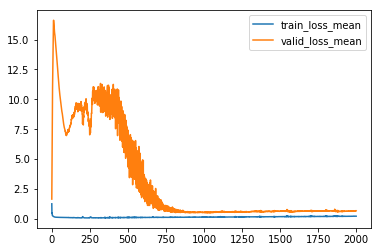

In [24]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss_mean, label='train_loss_mean')
mplot.plot(valid_loss_mean, label='valid_loss_mean')
mplot.legend()

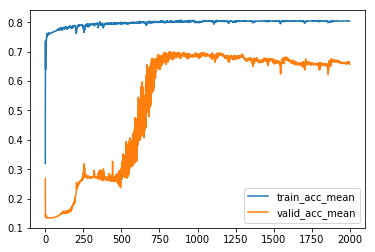

In [25]:
mplot.plot(train_acc_mean, label='train_acc_mean')
mplot.plot(valid_acc_mean, label='valid_acc_mean')
mplot.legend()

In [26]:
with tf.Session() as sess:
    #sess.run(fetches=tf.global_variables_initializer())
    
    # Restoring/loading/uploading the trained and validated model
    #saver.restore(sess,'checkpoints/model.ckpt')
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints/'))
    
    # Saving the test loss for every batch/minibtch
    test_loss, test_acc = [], []
    
    # Testing
    for Xinputs, Yindices in get_batches(X=Xtest, Y=Ytest, batch_size=batch_size):
        feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices, model.training: False}
        loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
        test_loss.append(loss)
        test_acc.append(acc)
        
    # Printing the test loss
    print('test_loss:', np.mean(test_loss), 'test acc', np.mean(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/model-imu.ckpt
test_loss: 1.3105887 test acc 0.5231188
